In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, SubsetRandomSampler,DataLoader
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
# from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
import random

In [ ]:
!unzip /content/drive/MyDrive/Inian_sign_language.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/V/819.jpg          
  inflating: data/V/82.jpg           
  inflating: data/V/820.jpg          
  inflating: data/V/821.jpg          
  inflating: data/V/822.jpg          
  inflating: data/V/823.jpg          
  inflating: data/V/824.jpg          
  inflating: data/V/825.jpg          
  inflating: data/V/826.jpg          
  inflating: data/V/827.jpg          
  inflating: data/V/828.jpg          
  inflating: data/V/829.jpg          
  inflating: data/V/83.jpg           
  inflating: data/V/830.jpg          
  inflating: data/V/831.jpg          
  inflating: data/V/832.jpg          
  inflating: data/V/833.jpg          
  inflating: data/V/834.jpg          
  inflating: data/V/835.jpg          
  inflating: data/V/836.jpg          
  inflating: data/V/837.jpg          
  inflating: data/V/838.jpg          
  inflating: data/V/839.jpg          
  inflating: data/V/84.jpg           
  inflating: data/V/840.jpg          

In [ ]:
class IndianSignLanguageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels = sorted(os.listdir(root_dir))
        self.label_to_idx = {label: idx for idx, label in enumerate(self.labels)}
        self.image_paths = []
        for label in self.labels:
            label_dir = os.path.join(root_dir, label)
            for image_path in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label, image_path))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = os.path.join(self.root_dir, self.image_paths[index])
        image = Image.open(image_path).convert('RGB')
        label = self.label_to_idx[image_path.split(os.sep)[-2]]
        if self.transform:
            image = self.transform(image)
        return image, label



In [ ]:

# Define the transforms to be applied to the dataset
transform = transforms.Compose(
    [transforms.Resize((128, 128)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomRotation(degrees=(-30, 30)),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-30, 30), translate=(0.1, 0.1), scale=(0.9, 1.1), shear=(-10, 10)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

# Create the dataset
my_dataset = IndianSignLanguageDataset(root_dir="/content/data", transform=transform)


# Shuffle the dataset
shuffled_indices = torch.randperm(len(my_dataset)).tolist()
my_dataset = torch.utils.data.Subset(my_dataset, shuffled_indices)

# # Define the size of the training set
# train_size = int(0.8 * len(my_dataset))
# test_size = len(my_dataset) - train_size

# # Define the indices for the training and testing sets
# train_indices, test_indices = shuffled_indices[:train_size], shuffled_indices[train_size:]
# Define the size of the training, validation, and testing sets
train_size = int(0.7 * len(my_dataset))
val_size = int(0.1 * len(my_dataset))
test_size = len(my_dataset) - train_size - val_size

# Define the indices for the training, validation, and testing sets
train_indices = shuffled_indices[:train_size]
val_indices = shuffled_indices[train_size:train_size + val_size]
test_indices = shuffled_indices[train_size + val_size:]

In [ ]:
print(train_indices)
print(test_indices)
print(val_indices)

[22509, 19832, 35543, 29667, 23896, 6816, 41496, 22992, 39651, 25951, 26342, 38549, 6777, 27089, 17288, 28064, 9458, 8648, 33631, 29832, 14963, 41896, 2389, 206, 11882, 7906, 28891, 4191, 25698, 96, 12646, 5106, 1684, 37668, 35300, 30906, 25644, 25566, 23824, 35360, 11471, 31504, 4561, 40491, 16382, 26568, 540, 23841, 35209, 29272, 7190, 39256, 16329, 26665, 13371, 23726, 40154, 8224, 39616, 792, 4953, 7192, 30723, 40611, 793, 17919, 31320, 20668, 22287, 39495, 7111, 6764, 1704, 6467, 5616, 32277, 38277, 19420, 32473, 40805, 31549, 16222, 15092, 24845, 12345, 31622, 10399, 27123, 19791, 2228, 41040, 1857, 38371, 13051, 32284, 33951, 34482, 9592, 31083, 39199, 1793, 32459, 1732, 38789, 30147, 19781, 34530, 40612, 16190, 12494, 32264, 24035, 11772, 24838, 2218, 11917, 26561, 13196, 19080, 21453, 29082, 9404, 11294, 39709, 25742, 22535, 28584, 13279, 27292, 27643, 20671, 36652, 26963, 7708, 1468, 23963, 23667, 2214, 24857, 29606, 22179, 25620, 14965, 25151, 39015, 25105, 40919, 16342, 152

In [ ]:
# Create the data samplers for the training and testing sets
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
val_sampler = SubsetRandomSampler(val_indices)

In [ ]:
# Create the data loaders for the training and testing sets
train_loader = DataLoader(my_dataset, batch_size=64, sampler=train_sampler)
test_loader = DataLoader(my_dataset, batch_size=64, sampler=test_sampler)
val_loader = DataLoader(my_dataset, batch_size=64, sampler=val_sampler)

In [ ]:
# Print the shape of each batch and corresponding labels
for i, (images, labels) in enumerate(train_loader):
    print(f"Batch {i+1} - Image Shape: {images.shape}, Labels: {labels}")
    if i==2:
      break

Batch 1 - Image Shape: torch.Size([64, 3, 128, 128]), Labels: tensor([ 8, 32, 25,  7, 19, 14, 20, 30,  0, 21, 19,  0, 30, 23, 14, 20,  2, 33,
        28, 25,  7, 25,  5, 10, 30,  5, 26,  6,  5,  4, 26, 32, 21, 17, 32,  8,
        32, 15,  2,  0, 26, 11, 20, 12,  6,  8, 30, 11, 32,  3, 10, 23,  2, 14,
         8, 12,  1,  8, 19, 11,  1, 28, 20, 30])
Batch 2 - Image Shape: torch.Size([64, 3, 128, 128]), Labels: tensor([ 6, 24, 23,  0,  2, 11, 18, 21,  1,  8, 10, 13,  3, 22, 33, 17, 24,  5,
        31, 16,  3, 22, 29,  3, 28, 25, 23,  5,  0, 16, 28,  0,  3, 15, 11,  7,
        13,  0, 14, 31, 32, 25,  3, 29, 13, 10, 22,  1, 31,  4,  7, 30, 18, 27,
        11, 21, 24,  7, 33, 30, 12, 10,  4, 12])
Batch 3 - Image Shape: torch.Size([64, 3, 128, 128]), Labels: tensor([16, 11,  6, 29,  5, 27, 30,  2,  9, 10, 23, 23, 24, 34, 15, 27, 24, 22,
        19, 13, 11, 33, 11,  9, 21,  6, 28,  7, 28, 14,  8,  0,  1, 26, 23, 17,
        19, 16,  6, 20, 30,  6,  3, 17,  6, 17,  0,  2, 12,  7,  1, 31, 14, 

In [ ]:
# Print the shape of each batch and corresponding labels
for i, (images, labels) in enumerate(test_loader):
    print(f"Batch {i+1} - Image Shape: {images.shape}, Labels: {labels}")
    if i==2:
      break

Batch 1 - Image Shape: torch.Size([64, 3, 128, 128]), Labels: tensor([16, 18,  1, 18, 14, 31,  1, 33, 23, 20,  7, 14, 31, 20, 28, 25, 15,  6,
        32,  6, 13, 26,  6,  1,  5, 21,  3, 28, 12, 29,  1, 28, 16,  9, 23,  7,
        20,  6, 13,  1, 22,  3, 28, 33,  6, 30, 11, 25,  6, 11, 32, 17, 19, 10,
        32, 27, 34, 31, 23,  7, 23,  2, 34, 25])
Batch 2 - Image Shape: torch.Size([64, 3, 128, 128]), Labels: tensor([19,  0,  6, 26, 23, 28, 27, 19, 12, 22, 11, 26, 14,  5, 22, 18,  9, 26,
        17, 10, 11, 11, 12, 15,  0, 21,  1, 27, 19,  8,  5, 23,  6, 15, 21,  2,
         6, 21,  6, 25, 11, 24, 33, 34,  9, 24, 19, 33,  4, 20, 23, 22,  8, 26,
         2, 15, 10,  6, 12, 32, 34, 21,  4, 34])
Batch 3 - Image Shape: torch.Size([64, 3, 128, 128]), Labels: tensor([18, 17, 28,  3, 14, 14, 20,  5, 12, 13,  4, 24,  7, 14, 23,  8, 21,  7,
        32, 25, 29, 31, 34, 22, 21,  6, 21,  9, 32,  2, 14,  2, 13, 17, 13, 31,
        23, 27,  6, 25, 22, 33, 14, 23, 26, 14, 23,  4,  8, 14, 13, 12,  7, 

In [ ]:
print(len(train_loader))
print(len(test_loader))

460
132


In [ ]:
import torch.nn.init as init
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
         #input shape is [batch=32,channels=3,size = 128*128] and 3 filters
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding=1) 
        #new shape = [32,3,128,128]
        # self.bn1 = nn.BatchNorm2d(5)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=5, kernel_size=3, padding=1)
        #new shape = [32,5,128,128]
        self.bn2 = nn.BatchNorm2d(5)
        self.conv3 = nn.Conv2d(in_channels=5, out_channels=6, kernel_size=3, padding=1)
        #new shape = [32,6,64,64]
        # self.bn3 = nn.BatchNorm2d(7)
        self.conv4 = nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, padding=1)
        #new shape = [32,6,64,64]
        self.bn4 = nn.BatchNorm2d(6)
        self.conv5 = nn.Conv2d(in_channels=6, out_channels=8, kernel_size=3, padding=1)
        #new shape = [32,8,32,32]
        # self.bn5 = nn.BatchNorm2d(9)
        self.conv6 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1)
        #new shape = [32,8,16,16]
        self.bn6 = nn.BatchNorm2d(8)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=8 * 16 * 16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=35)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.bn6(self.conv6(x))))
        x = x.view(-1, 8 * 16 * 16)
        x = F.relu(self.dropout(self.fc1(x)))
        x = self.fc2(x)
        # x = F.softmax(x, dim=1)  # Apply softmax activation
        return x


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                init.constant_(m.bias, 0)



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [ ]:
import random
import torch.nn.functional as F

# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)

# Define the L1 regularization strength
l1_lambda = 0.001

# Train the model
train_losses = []
val_losses = []
train_total = 0
train_correct = 0
val_total = 0
val_correct = 0

for epoch in range(20):
    # Training steps...
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # Calculate the loss

        # L1 regularization
        l1_regularization = torch.tensor(0., device=device)
        for param in model.parameters():
            l1_regularization += torch.norm(param, p=1)

        loss += l1_lambda * l1_regularization

        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Optimize the weights
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            train_losses.append(running_loss / 100)
            running_loss = 0.0
            
        # Update total and correct variables for training accuracy
        train_total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()

    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        for data in val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            # Compute test accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate loss for the batch and update running loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    # Compute test accuracy and loss for the epoch
    val_accuracy = 100 * val_correct / val_total
    val_loss = running_loss / len(val_loader)
    val_losses.append(val_loss)

    # Print test accuracy and loss for the epoch
    print('Epoch %d, val Loss: %.3f, val Accuracy: %.3f' % (epoch + 1, val_loss, val_accuracy))

    # Compute and print training accuracy
    train_accuracy = 100 * train_correct / train_total
    print('Epoch %d, Training Accuracy: %.3f' % (epoch + 1, train_accuracy))

    # if test_loss>loss:
    #   break




[1,   100] loss: 5.315
[1,   200] loss: 5.241
[1,   300] loss: 5.186
[1,   400] loss: 5.143
Epoch 1, val Loss: 8.128, val Accuracy: 7.214
Epoch 1, Training Accuracy: 3.953
[2,   100] loss: 5.030
[2,   200] loss: 4.948
[2,   300] loss: 4.848
[2,   400] loss: 4.714
Epoch 2, val Loss: 7.308, val Accuracy: 10.012
Epoch 2, Training Accuracy: 7.204
[3,   100] loss: 4.471
[3,   200] loss: 4.302
[3,   300] loss: 4.106
[3,   400] loss: 3.913
Epoch 3, val Loss: 5.787, val Accuracy: 17.389
Epoch 3, Training Accuracy: 12.117
[4,   100] loss: 3.577
[4,   200] loss: 3.402
[4,   300] loss: 3.246
[4,   400] loss: 3.105
Epoch 4, val Loss: 4.445, val Accuracy: 25.554
Epoch 4, Training Accuracy: 19.687
[5,   100] loss: 2.917
[5,   200] loss: 2.846
[5,   300] loss: 2.734
[5,   400] loss: 2.698
Epoch 5, val Loss: 3.753, val Accuracy: 32.143
Epoch 5, Training Accuracy: 26.773
[6,   100] loss: 2.568
[6,   200] loss: 2.528
[6,   300] loss: 2.473
[6,   400] loss: 2.432
Epoch 6, val Loss: 3.364, val Accuracy: 3

In [ ]:
print(train_losses)

[5.3151142072677615, 5.241040210723877, 5.1856586503982545, 5.14298002243042, 5.0304749488830565, 4.948183279037476, 4.8481920337677, 4.714227533340454, 4.471024227142334, 4.302380647659302, 4.106261751651764, 3.9129220151901247, 3.577233190536499, 3.4019184160232543, 3.2462334847450256, 3.104527487754822, 2.917097668647766, 2.8456880140304563, 2.73418625831604, 2.698310577869415, 2.5684628438949586, 2.5284827733039856, 2.473366277217865, 2.431929066181183, 2.370110709667206, 2.3110547280311584, 2.3094247543811797, 2.2695433044433595, 2.226025626659393, 2.156958156824112, 2.181182656288147, 2.135095992088318, 2.095739084482193, 2.085584146976471, 2.065724149942398, 2.0270151495933533, 1.9850780189037323, 1.985041778087616, 1.9490630698204041, 1.945155930519104, 1.9213957643508912, 1.8895208573341369, 1.8910303819179535, 1.8881948339939116, 1.8487093150615692, 1.823044821023941, 1.836310293674469, 1.8020020508766175, 1.789778252840042, 1.773708165884018, 1.7503172934055329, 1.7675452566

In [ ]:
# Initialize a new list to store the loss values for every 5th element
train_losses_5th = []

for i, loss in enumerate(train_losses, 1):
    if i % 4 == 0:
        train_losses_5th.append(loss)

# Print the loss values for every 5th element
print(train_losses_5th)


[5.14298002243042, 4.714227533340454, 3.9129220151901247, 3.104527487754822, 2.698310577869415, 2.431929066181183, 2.2695433044433595, 2.135095992088318, 2.0270151495933533, 1.945155930519104, 1.8881948339939116, 1.8020020508766175, 1.767545256614685, 1.6843282902240753, 1.6712707734107972, 1.6180657315254212, 1.5684234344959258, 1.5357928228378297, 1.5169791460037232, 1.4650988602638244]


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

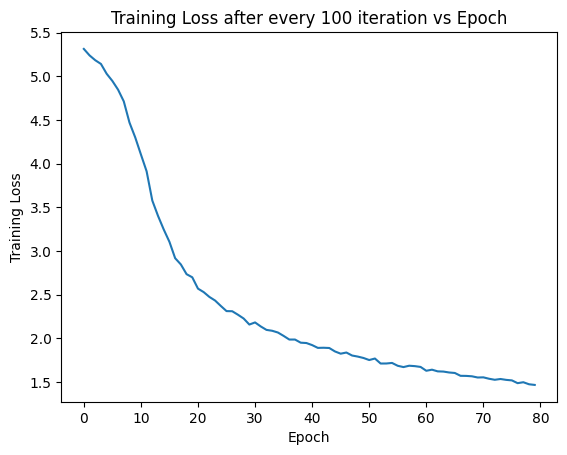

Finished Training


In [ ]:
# Plot training loss vs epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss after every 100 iteration vs Epoch')
plt.show()

print('Finished Training')

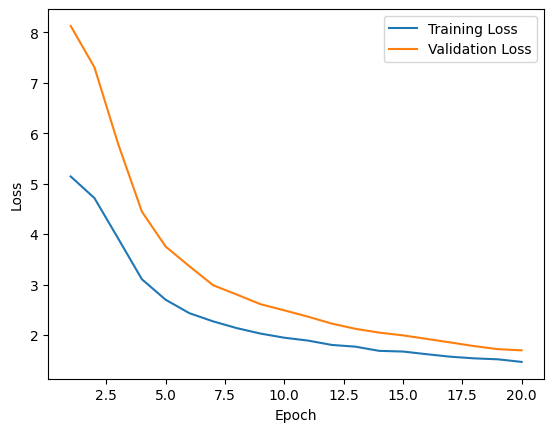

In [ ]:
# Plot the training loss and validation loss curve
plt.figure()
plt.plot(range(1, len(train_losses_5th) + 1), train_losses_5th, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save the model, optimizer, and training history to a checkpoint file
checkpoint = {'modelfinal1': model.state_dict(),
              'optimizerfinal1': optimizer.state_dict(),
              'train_lossesfinal1': train_losses}
torch.save(checkpoint, 'checkpointfinal2.pth')


In [41]:
# Load the checkpoint file
checkpoint = torch.load('checkpointfinal2.pth')

# # # Create a new model and optimizer
# model = CNN().to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Load the saved model and optimizer states
model.load_state_dict(checkpoint['modelfinal1'])
# optimizer.load_state_dict(checkpoint['optimizerfinal1'])
# Put the model in evaluation mode
# model.eval()

class_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

# Create empty lists to store true labels and predicted labels
true_labels = []
pred_labels = []

# Loop through the test data and make predictions
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels += labels.tolist()
        pred_labels += predicted.tolist()

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=range(len(class_names)))

# Calculate the overall and classwise accuracy
acc = accuracy_score(true_labels, pred_labels)*100
report = classification_report(true_labels, pred_labels,target_names=class_names)

print(f"Confusion Matrix:\n{cm}")
print(f"\nOverall Accuracy: {acc}")
print(f"\nClassification Report:\n{report}")


Confusion Matrix:
[[240   0   0 ...   0   0   0]
 [  0 226   0 ...   2   0   0]
 [  0   0 241 ...   0   0   0]
 ...
 [  0   0   0 ... 212   0   0]
 [  0   0   0 ...   0 184  15]
 [  0   0   0 ...   0  10 187]]

Overall Accuracy: 90.1916438519224

Classification Report:
              precision    recall  f1-score   support

           1       0.94      0.91      0.92       265
           2       0.93      0.94      0.94       240
           3       0.87      0.95      0.90       255
           4       0.93      0.95      0.94       259
           5       0.90      0.93      0.91       224
           6       0.93      0.89      0.91       236
           7       0.97      0.98      0.98       259
           8       0.92      0.90      0.91       242
           9       0.93      0.86      0.89       256
           A       0.90      0.85      0.87       235
           B       0.98      0.85      0.91       236
           C       0.92      0.90      0.91       259
           D       0.90    

In [42]:
import numpy as np

# Save the confusion matrix to a file
np.savetxt('confusion_matrixfinal.txt', cm, fmt='%d')

# Load the file contents and print
with open('confusion_matrixfinal.txt', 'r') as file:
    confusion_matrix_text = file.read()

print('Confusion Matrix:')
print(confusion_matrix_text)


Confusion Matrix:
240 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 9 0 0 6 0 0 0 0 0 0 0 0 8 0 0 0 0 0
0 226 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 3 0 2 0 0
0 0 241 0 0 2 0 0 3 0 0 7 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
2 0 0 247 0 0 1 0 0 0 0 0 0 0 3 0 0 0 0 0 1 0 4 0 0 0 0 1 0 0 0 0 0 0 0
0 0 0 0 208 0 0 5 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 8 0 0 0 0 1 0 0 0
0 0 18 0 0 209 0 0 6 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
0 3 0 0 0 0 254 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0
0 0 0 0 1 0 0 218 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 21 0 0 0 0 1 0 0 0
0 0 3 0 8 8 0 0 221 0 0 4 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 4 0 0 0
0 0 0 0 0 0 0 0 0 199 0 0 0 3 0 2 0 0 0 0 0 0 0 0 0 9 0 3 0 2 0 0 0 12 5
0 0 0 0 0 0 0 0 0 0 201 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 34 0 0
0 0 13 0 0 1 0 0 5 0 0 234 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 2 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 216 10 1 0 0 0 5 0 0 0 2 0 0 0 0 13 0 0 0 1 0 0 7
0 0 0 0 0 0 0 0 0 1 0 0 3 215 0 0 0 0 0

In [45]:
class_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

# Create empty lists to store true labels and predicted labels
true_labels = []
pred_labels = []

# Create empty list to store predicted values and original values side by side
predictions = []

# Loop through the test data and make predictions
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels += labels.tolist()
        pred_labels += predicted.tolist()
        
        # Append predicted and original values side by side
        for true_label, pred_label in zip(labels.tolist(), predicted.tolist()):
            predictions.append((class_names[true_label], class_names[pred_label]))

# # Calculate the confusion matrix
# cm = confusion_matrix(true_labels, pred_labels, labels=range(len(class_names)))

# Calculate the overall and classwise accuracy
acc = accuracy_score(true_labels, pred_labels) * 100
report = classification_report(true_labels, pred_labels, target_names=class_names)

# print(f"Confusion Matrix:\n{cm}")
# print(f"\nOverall Accuracy: {acc}")
# print(f"\nClassification Report:\n{report}")

# Print predicted values and original values side by side
for true_label, pred_label in predictions:
    print(f"True: {true_label}\tPredicted: {pred_label}")


Streaming output truncated to the last 5000 lines.
True: 4	Predicted: 4
True: P	Predicted: E
True: L	Predicted: L
True: R	Predicted: R
True: Q	Predicted: Q
True: K	Predicted: K
True: Y	Predicted: Y
True: O	Predicted: O
True: I	Predicted: I
True: B	Predicted: B
True: T	Predicted: T
True: F	Predicted: F
True: A	Predicted: Z
True: 8	Predicted: 8
True: Y	Predicted: Y
True: N	Predicted: N
True: 7	Predicted: 7
True: V	Predicted: V
True: 6	Predicted: 6
True: K	Predicted: K
True: X	Predicted: X
True: Z	Predicted: Z
True: G	Predicted: G
True: R	Predicted: R
True: 1	Predicted: I
True: K	Predicted: K
True: E	Predicted: E
True: U	Predicted: U
True: Y	Predicted: Y
True: N	Predicted: N
True: U	Predicted: U
True: 1	Predicted: 1
True: B	Predicted: B
True: 3	Predicted: 3
True: H	Predicted: H
True: 6	Predicted: 6
True: I	Predicted: I
True: Z	Predicted: Y
True: W	Predicted: W
True: O	Predicted: O
True: R	Predicted: R
True: 6	Predicted: 6
True: L	Predicted: L
True: Z	Predicted: Z
True: C	Predicted: C
True